In [40]:
import os
import shutil
import random

import pandas as pd
import numpy as np

from scipy.stats import shapiro, levene, bartlett, ttest_ind

import matplotlib.pyplot as plt
%matplotlib inline

import gc

import torch
print(torch.cuda.is_available())

from ultralytics import YOLO

np.random.seed(42)

True


In [2]:
df = pd.DataFrame(columns=["environment", "mAP50", "mAP50-95"])
environments = []
mAP50s = []
mAP50_95s = [] 

In [3]:
WEIGHTS_PATH = "./runs/weights_normal/350_imgs/weights/best.pt"

In [4]:
def remove_cache():
    for environment in ["dessert", "rural", "snow"]:
        path = f"./data/bias/{environment}/"
        try:
            os.remove(path+"valid/labels.cache")
        except:
            pass

In [5]:
def generate_sample():
    for environment in ["dessert", "rural", "snow"]:
        path = f"./data/bias/{environment}/"

        all_images = os.listdir(path+"all/images/")
        sample_imgs = random.sample(all_images, 30)
        sample_labels = [img[:-3]+"txt" for img in sample_imgs]

        [os.remove(path+"valid/images/"+img) for img in os.listdir(path+"valid/images/")] #remove previous sample images
        [os.remove(path+"valid/labels/"+label) for label in os.listdir(path+"valid/labels/")] #remove previous sample labels

        [shutil.copy(path+"all/images/"+img, path+"valid/images/"+img) for img in sample_imgs] #make new sample images
        [shutil.copy(path+"all/labels/"+label, path+"valid/labels/"+label) for label in sample_labels] #make new sample labels

In [6]:
for _ in range(0,100):
    remove_cache()
    generate_sample()
    
    model = YOLO(WEIGHTS_PATH)
    
    #dessert
    DATA_PATH = "E:\\OU\\master\\rm\\pre_shot_sniper_detection\\data\\data_aug_bias_dessert.yaml"
    results_dessert = model.val(data=DATA_PATH, device="cpu")

    environments.append("dessert")
    mAP50s.append(results_dessert.results_dict['metrics/mAP50(B)'])
    mAP50_95s.append(results_dessert.results_dict['metrics/mAP50-95(B)'])
    
    #snow
    DATA_PATH = "E:\\OU\\master\\rm\\pre_shot_sniper_detection\\data\\data_aug_bias_snow.yaml"
    results_snow = model.val(data=DATA_PATH, device="cpu")

    environments.append("snow")
    mAP50s.append(results_snow.results_dict['metrics/mAP50(B)'])
    mAP50_95s.append(results_snow.results_dict['metrics/mAP50-95(B)'])
    
    #rural
    DATA_PATH = "E:\\OU\\master\\rm\\pre_shot_sniper_detection\\data\\data_aug_bias_rural.yaml"
    results_rural = model.val(data=DATA_PATH, device="cpu")

    environments.append("rural")
    mAP50s.append(results_rural.results_dict['metrics/mAP50(B)'])
    mAP50_95s.append(results_rural.results_dict['metrics/mAP50-95(B)'])
    
    #free up GPU memory
    del model
    gc.collect()
    torch.cuda.empty_cache()

Ultralytics YOLOv8.0.200  Python-3.9.18 torch-2.1.0+cu118 CPU (13th Gen Intel Core(TM) i5-13600KF)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning E:\OU\master\rm\pre_shot_sniper_detection\data\bias\dessert\valid\labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 789.54it/s]
val: New cache created: E:\OU\master\rm\pre_shot_sniper_detection\data\bias\dessert\valid\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]
                   all         30         35      0.693      0.457      0.497       0.28
Speed: 1.1ms preprocess, 38.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\val91
Ultralytics YOLOv8.0.200  Python-3.9.18 torch-2.1.0+cu118 CPU (13th Gen Intel Core(TM) i5-13600KF)
val: Scanning E:\OU\master\rm\pre_shot_sniper_detection\data\bias\snow\valid\labels... 30 images, 0 b

# Stat analysis

In [8]:
df["environment"] = environments
df["mAP50"] = mAP50s
df["mAP50-95"] = mAP50_95s
#df.to_csv('./excel/bias.csv')
df.head(10)

,environment,mAP50,mAP50-95
0,dessert,0.496970,0.279537
1,snow,0.578072,0.328125
2,rural,0.758120,0.480915
3,dessert,0.506833,0.259565
4,snow,0.640908,0.382660
5,rural,0.663684,0.417832
6,dessert,0.526435,0.306350
7,snow,0.513134,0.268031
8,rural,0.679751,0.431736
9,dessert,0.654795,0.339242


## Normality check

In [10]:
df_dessert = df[df["environment"] == "dessert"]
df_snow = df[df["environment"] == "snow"]
df_rural = df[df["environment"] == "rural"]

### Visual

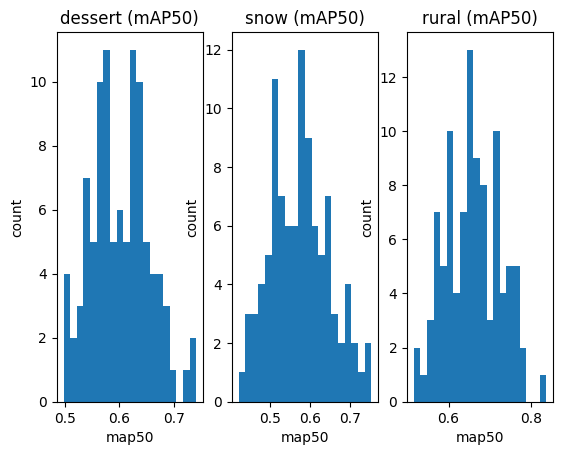

In [18]:
fig, axs = plt.subplots(ncols=3, nrows=1)

axs[0].hist(df_dessert["mAP50"], bins=20)
axs[0].title.set_text('dessert (mAP50)')
axs[0].set_xlabel("map50")
axs[0].set_ylabel("count")

axs[1].hist(df_snow["mAP50"], bins=20)
axs[1].title.set_text('snow (mAP50)')
axs[1].set_xlabel("map50")
axs[1].set_ylabel("count")

axs[2].hist(df_rural["mAP50"], bins=20)
axs[2].title.set_text('rural (mAP50)')
axs[2].set_xlabel("map50")
axs[2].set_ylabel("count")

fig.savefig('./viz_img/bias_normality_hist.png')

### Shapiro-Wilk Test

In [25]:
print(f'dessert shapiro-wilk test p-value: {shapiro(df_dessert["mAP50"])[0]}')
print(f'snow shapiro-wilk test p-value: {shapiro(df_snow["mAP50"])[0]}')
print(f'rural shapiro-wilk test p-value: {shapiro(df_rural["mAP50"])[0]}')

dessert shapiro-wilk test p-value: 0.9855102300643921
snow shapiro-wilk test p-value: 0.9847775101661682
rural shapiro-wilk test p-value: 0.9891202449798584


## Equal variance check

In [56]:
dessert_snow_levene = levene(df_dessert["mAP50"], df_snow["mAP50"])[1]
dessert_rural_levene = levene(df_dessert["mAP50"], df_rural["mAP50"])[1]
snow_rural_levene = levene(df_snow["mAP50"], df_rural["mAP50"])[1]
all_three = levene(df_snow["mAP50"], df_rural["mAP50"], df_dessert["mAP50"])[1]

print(f"Dessert and snow {'' if dessert_snow_levene > 0.05 else 'do not'} have equal variance (levene p-value: {dessert_snow_levene})")
print(f"Dessert and rural {'' if dessert_rural_levene > 0.05 else 'do not'} have equal variance (levene p-value: {dessert_rural_levene})")
print(f"snow and rural {'' if snow_rural_levene > 0.05 else 'do not'} have equal variance (levene p-value: {snow_rural_levene})")

print(f"All three {'' if all_three > 0.05 else 'do not'} have equal variance (levene p-value: {all_three})")


Dessert and snow do not have equal variance (levene p-value: 0.007169515889316398)
Dessert and rural  have equal variance (levene p-value: 0.09213842610394112)
snow and rural  have equal variance (levene p-value: 0.30160577162333624)
All three do not have equal variance (levene p-value: 0.027989335294336958)


## (Welch's) T-test

In [57]:
dessert_snow_ttest = ttest_ind(df_dessert["mAP50"], df_snow["mAP50"], equal_var=False)[1]
dessert_rural_ttest = ttest_ind(df_dessert["mAP50"], df_rural["mAP50"], equal_var=True)[1]
snow_rural_ttest = ttest_ind(df_snow["mAP50"], df_rural["mAP50"], equal_var=True)[1]

print(f"Dessert and snow {'' if dessert_snow_ttest > 0.05 else 'do not'} have a significant difference (T-test p-value: {dessert_snow_ttest})")
print(f"Dessert and rural {'' if dessert_rural_ttest > 0.05 else 'do not'} have a significant difference (T-test p-value: {dessert_rural_ttest})")
print(f"snow and rural {'' if snow_rural_ttest > 0.05 else 'do not'} have a significant difference (T-test p-value: {snow_rural_ttest})")

Dessert and snow do not have a significant difference (T-test p-value: 0.0036444347630368453)
Dessert and rural do not have a significant difference (T-test p-value: 2.6349453920703943e-10)
snow and rural do not have a significant difference (T-test p-value: 6.018863620005367e-15)
